# Experiments based on DPAv4.2 (unprotected)
```Assuming that masks are known to the attacker, which view this dataset as a unprotected plain AES-256 implementation.```

In [1]:
import numpy as np
import os
from src.utils import Sbox, coeff
import matplotlib.pyplot as plt
import random
from src.augmentations import addClockJitter, addDesync
from src.sample import traces_random_start, traces_raw
import sys
sys.path.append("..") 

num_train = 4000
num_valid = 500
num_attack = 500
trace_offset = 270000
trace_length = 2000
path = '/run/media/declan/sda1/open_dataset/DPA_v4_2_dataset_all'

folder_path = path+'/ACNN/pre-aug'
os.makedirs(folder_path,exist_ok=True)

aug_folder_path = path+'/ACNN/post-aug'
os.makedirs(aug_folder_path, exist_ok=True)

attack_c1_folder_path = path+'/ACNN/attack/c1'
os.makedirs(attack_c1_folder_path, exist_ok=True)

attack_c2_folder_path = path+'/ACNN/attack/c2'
os.makedirs(attack_c2_folder_path, exist_ok=True)

effect_folder_path = path+'/ACNN/attack/effect'
os.makedirs(effect_folder_path, exist_ok=True)

# Profiling
> loading DPAv4.2 traces
>> training/validation set: (4000, 2000)/(500,2000)  
>> attacking set: (500, 300000)

In [2]:
Xt = np.load(path+'/traces_k00_0w_30w.npy')[:num_train+num_valid,trace_offset:trace_offset+trace_length]
Xa = np.load(path+'/traces_k00_0w_30w.npy')[num_train+num_valid:num_train+num_valid+num_attack,:]
P = np.load(path+'/plaintext00.npy')[:num_train+num_valid+num_attack,0]

key = np.load(path+"/key00.npy")[0]
offset = np.load(path+"/offset00.npy")[:num_train+num_valid+num_attack:,0]
mask = np.array([3,12,53,58,80,95,102,105,150,153,160,175,197,202,243,252])
R =  mask[(offset+1)%16]
Y = Sbox[P^key]^R # class label
Yt, Ya = Y[:num_train+num_valid], Y[num_train+num_valid:]
Rt, Ra = R[:num_train+num_valid], R[num_train+num_valid:]
Pt, Pa = P[:num_train+num_valid], P[num_train+num_valid:]

np.save(folder_path+'/X_train.npy', Xt)
np.save(folder_path+'/X_attack.npy',Xa)
np.save(folder_path+'/Y_train.npy',Yt)
np.save(folder_path+'/Y_attack.npy',Ya)
np.save(folder_path+'/R_train.npy', Rt)
np.save(folder_path+'/R_attack.npy', Ra)
np.save(folder_path+'/P_train.npy', Pt)
np.save(folder_path+'/P_attack.npy', Pa)

## AOI Label

### Locating

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


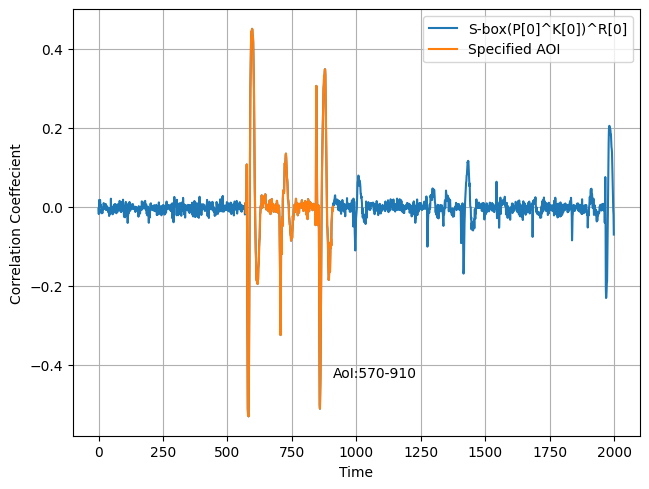

In [3]:
co = coeff(Xt.T, Yt)

ps, pe = 570,910
pr = pe - ps
plt.plot(co, label='S-box(P[0]^K[0])^R[0]')
plt.plot(np.arange(ps, pe),co[ps:pe], label='Specified AOI')

plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.ylabel('Correlation Coeffecient')
plt.xlabel('Time')
plt.text(pe, -0.43, f'AoI:{ps}-{pe}')
plt.savefig('./output/AOI_DPAv4.eps', format='eps')

### augmentation

In [4]:
Xt = np.load(folder_path+'/X_train.npy')
Yt = np.load(folder_path+'/Y_train.npy').reshape(-1,1)

Xt_newpspe, Xt_jitter_trs = addClockJitter(Xt, [ps, pe], 2000, 1)
Xt_desync_offset_1, Xt_augment_trs = addDesync(Xt_jitter_trs, max_desync=150)

Xt_desync_offset_2, Xt_trs = addDesync(Xt, max_desync=150)

Xt_augment_trs = np.concatenate((Xt_augment_trs, Xt_trs), axis=0)
print(Xt_augment_trs.shape)

(9000, 2000)


## Label

In [5]:
# label for training and validation set: (ps, pr, class)
ps1, pe1 = Xt_newpspe[:,0:1], Xt_newpspe[:,1:2] # ps, pe after addClockJitter

pr1 = pe1 - ps1
ps1 = ps1 - Xt_desync_offset_1.reshape(-1, 1) # Desyn changes ps

pr2 = (np.ones_like(Yt)*pr)
ps2 = np.ones_like(Yt)*ps - Xt_desync_offset_2.reshape(-1, 1)

Yt_det = np.concatenate([np.concatenate((ps1+pr1//2, ps2+pr2//2),0),
                         np.concatenate((pr1, pr2),0),
                         np.concatenate((Yt, Yt),0)],1)
                         
# randomly shift the post-augmented traces
l = list(zip(Xt_augment_trs, Yt_det))
random.shuffle(l)
Xt_augment_trs, Yt_det = list(zip(*l))
Xt_augment_trs, Yt_det = np.array(Xt_augment_trs), np.array(Yt_det)

In [6]:
# split into training and validation set
np.save(aug_folder_path+'/X_train.npy', Xt_augment_trs[:num_train*2])
np.save(aug_folder_path+'/X_valid.npy', Xt_augment_trs[num_train*2:])
np.save(aug_folder_path+'/Y_train.npy', Yt_det[:num_train*2])
np.save(aug_folder_path+'/Y_valid.npy', Yt_det[num_train*2:])

print(Xt_augment_trs.shape)
print(Yt_det.shape)
# so far, the preparation has completed.

(9000, 2000)
(9000, 3)


# Training

In [7]:
%%bash
# nb_train is doubled after data augmentation

python ./src/train.py --file_path='/run/media/declan/sda1/open_dataset/DPA_v4_2_dataset_all/ACNN/post-aug' \
                --model_save='./models' \
                --epoch=150 \
                --name=DPAv4 \
                --lr=1e-3 \
                --batch_size=256 \
                --trace_length=2000 \
                --nb_train=8000 \
                --nb_valid=500 \
                --nb_class=256 \
                --stride=150 \
                --weight_decay=1e-8 \
                --seed=-1 \

Environment information:
System: Linux 5.15.133-1-MANJARO
Not using the poetry package
Current Commit Hash: 930b7f7
Command line arguments: Namespace(file_path='/run/media/declan/sda1/open_dataset/DPA_v4_2_dataset_all/ACNN/post-aug', model_save='./models', epochs=150, model=None, name='DPAv4', lr=0.001, batch_size=256, weight_decay=1e-08, seed=-1, verbose=True, trace_length=2000, nb_train=8000, nb_valid=500, nb_class=256, stride=150)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 2000]              16
       BatchNorm1d-2              [-1, 4, 2000]               8
         LeakyReLU-3              [-1, 4, 2000]               0
         MaxPool1d-4               [-1, 4, 666]               0
            Conv1d-5               [-1, 8, 666]           1,640
       BatchNorm1d-6               [-1, 8, 666]              16
         LeakyReLU-7               [-1, 8, 666]  

Training Epoch 1: 100%|██████████| 32/32 [00:00<00:00, 67.30it/s]



---- Evaluating Model ----


Validation Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 35.74it/s]


Epoch-1
+--------------+---------------------+---------------------+
| Loss&Metric  | Train               | Validation          |
+--------------+---------------------+---------------------+
| leak loss    | 0.11711700679734349 | 0.03207096550613642 |
| no_leak loss | 0.28104114485904574 | 0.3804752826690674  |
| IoU loss     | 0.2370500061661005  | 0.27514810860157013 |
| class loss   | 5.655854865908623   | 5.784169673919678   |
| total loss   | 7.883695632219315   | 8.12204885482788    |
+--------------+---------------------+---------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 2: 100%|██████████| 32/32 [00:00<00:00, 129.88it/s]



---- Evaluating Model ----


Validation Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 39.73it/s]


Epoch-2
+--------------+---------------------+---------------------+
| Loss&Metric  | Train               | Validation          |
+--------------+---------------------+---------------------+
| leak loss    | 0.07671491988003254 | 0.05560995638370514 |
| no_leak loss | 0.18288965756073594 | 0.15237003564834595 |
| IoU loss     | 0.21706228703260422 | 0.25534361600875854 |
| class loss   | 5.614692986011505   | 5.639650106430054   |
| total loss   | 7.129778161644936   | 6.934893846511841   |
+--------------+---------------------+---------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 3: 100%|██████████| 32/32 [00:00<00:00, 123.67it/s]



---- Evaluating Model ----


Validation Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 39.64it/s]


Epoch-3
+--------------+---------------------+----------------------+
| Loss&Metric  | Train               | Validation           |
+--------------+---------------------+----------------------+
| leak loss    | 0.05689207080285996 | 0.060780756175518036 |
| no_leak loss | 0.12886109109967947 | 0.08406924828886986  |
| IoU loss     | 0.1985102565959096  | 0.23317622393369675  |
| class loss   | 5.574006885290146   | 5.581219911575317    |
| total loss   | 6.701283007860184   | 6.538646221160889    |
+--------------+---------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 4: 100%|██████████| 32/32 [00:00<00:00, 133.94it/s]



---- Evaluating Model ----


Validation Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 38.73it/s]


Epoch-4
+--------------+----------------------+---------------------+
| Loss&Metric  | Train                | Validation          |
+--------------+----------------------+---------------------+
| leak loss    | 0.042900533066131175 | 0.0420413613319397  |
| no_leak loss | 0.09684290317818522  | 0.07570954412221909 |
| IoU loss     | 0.18349400302395225  | 0.1675851121544838  |
| class loss   | 5.543603330850601    | 5.569100856781006   |
| total loss   | 6.4258144944906235   | 6.325440406799316   |
+--------------+----------------------+---------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 5: 100%|██████████| 32/32 [00:00<00:00, 124.70it/s]



---- Evaluating Model ----


Validation Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 39.46it/s]


Epoch-5
+--------------+---------------------+---------------------+
| Loss&Metric  | Train               | Validation          |
+--------------+---------------------+---------------------+
| leak loss    | 0.0336484924191609  | 0.03564676642417908 |
| no_leak loss | 0.0760523583739996  | 0.0561183076351881  |
| IoU loss     | 0.16506784921512008 | 0.1482567861676216  |
| class loss   | 5.525315493345261   | 5.559523820877075   |
| total loss   | 6.238887578248978   | 6.1666059494018555  |
+--------------+---------------------+---------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 6: 100%|██████████| 32/32 [00:00<00:00, 131.77it/s]



---- Evaluating Model ----


Validation Epoch 6: 100%|██████████| 2/2 [00:00<00:00, 38.91it/s]


Epoch-6
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.028315942792687565 | 0.025178938172757626 |
| no_leak loss | 0.059895990998484194 | 0.05136675760149956  |
| IoU loss     | 0.1427220432087779   | 0.13348882645368576  |
| class loss   | 5.510815232992172    | 5.55082893371582     |
| total loss   | 6.094596937298775    | 6.067046165466309    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 7: 100%|██████████| 32/32 [00:00<00:00, 128.11it/s]



---- Evaluating Model ----


Validation Epoch 7: 100%|██████████| 2/2 [00:00<00:00, 39.24it/s]


Epoch-7
+--------------+----------------------+---------------------+
| Loss&Metric  | Train                | Validation          |
+--------------+----------------------+---------------------+
| leak loss    | 0.02361311507411301  | 0.01859478559345007 |
| no_leak loss | 0.049248677445575595 | 0.05062921717762947 |
| IoU loss     | 0.12113535078242421  | 0.11331378668546677 |
| class loss   | 5.503618136048317    | 5.549334764480591   |
| total loss   | 5.9890624433755875   | 6.008768558502197   |
+--------------+----------------------+---------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 8: 100%|██████████| 32/32 [00:00<00:00, 133.21it/s]



---- Evaluating Model ----


Validation Epoch 8: 100%|██████████| 2/2 [00:00<00:00, 38.94it/s]


Epoch-8
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.020319661154644564 | 0.021874294616281986 |
| no_leak loss | 0.04153936298098415  | 0.034036312252283096 |
| IoU loss     | 0.10474791098386049  | 0.0987045131623745   |
| class loss   | 5.498541638255119    | 5.5503928661346436   |
| total loss   | 5.912584647536278    | 5.928650379180908    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 124.28it/s]



---- Evaluating Model ----


Validation Epoch 9: 100%|██████████| 2/2 [00:00<00:00, 38.41it/s]


Epoch-9
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.017922127241035923 | 0.01397969713434577  |
| no_leak loss | 0.03608579118736088  | 0.038626646623015404 |
| IoU loss     | 0.09506154176779091  | 0.10244830325245857  |
| class loss   | 5.4967788606882095   | 5.548415184020996    |
| total loss   | 5.861880004405975    | 5.91389536857605     |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 10: 100%|██████████| 32/32 [00:00<00:00, 131.34it/s]



---- Evaluating Model ----


Validation Epoch 10: 100%|██████████| 2/2 [00:00<00:00, 38.28it/s]


Epoch-10
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.016533887421246618 | 0.01479753665626049  |
| no_leak loss | 0.03152578993467614  | 0.031973524019122124 |
| IoU loss     | 0.09028820996172726  | 0.08760669082403183  |
| class loss   | 5.486876845359802    | 5.547914028167725    |
| total loss   | 5.817463397979736    | 5.869375944137573    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 11: 100%|██████████| 32/32 [00:00<00:00, 122.83it/s]



---- Evaluating Model ----


Validation Epoch 11: 100%|██████████| 2/2 [00:00<00:00, 36.95it/s]


Epoch-11
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.014845685684122145 | 0.011570222210139036 |
| no_leak loss | 0.02781997760757804  | 0.031161468476057053 |
| IoU loss     | 0.08498269389383495  | 0.0849473737180233   |
| class loss   | 5.483613073825836    | 5.540985584259033    |
| total loss   | 5.781924068927765    | 5.8395912647247314   |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 12: 100%|██████████| 32/32 [00:00<00:00, 126.14it/s]



---- Evaluating Model ----


Validation Epoch 12: 100%|██████████| 2/2 [00:00<00:00, 37.83it/s]


Epoch-12
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.014022259885678068 | 0.023084541782736778 |
| no_leak loss | 0.02465337101602927  | 0.01729324646294117  |
| IoU loss     | 0.08182505494914949  | 0.08390229940414429  |
| class loss   | 5.476077273488045    | 5.533005475997925    |
| total loss   | 5.751280441880226    | 5.818796634674072    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 13: 100%|██████████| 32/32 [00:00<00:00, 115.52it/s]



---- Evaluating Model ----


Validation Epoch 13: 100%|██████████| 2/2 [00:00<00:00, 38.80it/s]


Epoch-13
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.012702954118140042 | 0.01567569049075246  |
| no_leak loss | 0.02256514097098261  | 0.019110227935016155 |
| IoU loss     | 0.07889444706961513  | 0.07794805988669395  |
| class loss   | 5.467892333865166    | 5.527925252914429    |
| total loss   | 5.723127260804176    | 5.779803037643433    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 14: 100%|██████████| 32/32 [00:00<00:00, 130.75it/s]



---- Evaluating Model ----


Validation Epoch 14: 100%|██████████| 2/2 [00:00<00:00, 39.25it/s]


Epoch-14
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.011966677207965404 | 0.011089418083429337 |
| no_leak loss | 0.020465232839342207 | 0.020690666511654854 |
| IoU loss     | 0.07668252009898424  | 0.08012299239635468  |
| class loss   | 5.460976526141167    | 5.530226230621338    |
| total loss   | 5.6998186111450195   | 5.769249677658081    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 15: 100%|██████████| 32/32 [00:00<00:00, 116.38it/s]



---- Evaluating Model ----


Validation Epoch 15: 100%|██████████| 2/2 [00:00<00:00, 37.13it/s]


Epoch-15
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.011319024342810735 | 0.011668818071484566 |
| no_leak loss | 0.018826355691999197 | 0.019121235236525536 |
| IoU loss     | 0.07464386150240898  | 0.07693563401699066  |
| class loss   | 5.453471004962921    | 5.5215277671813965   |
| total loss   | 5.678841769695282    | 5.752413511276245    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 16: 100%|██████████| 32/32 [00:00<00:00, 126.86it/s]



---- Evaluating Model ----


Validation Epoch 16: 100%|██████████| 2/2 [00:00<00:00, 38.48it/s]


Epoch-16
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.010943419460090809 | 0.009664880111813545 |
| no_leak loss | 0.01733977600815706  | 0.019148745574057102 |
| IoU loss     | 0.07249193033203483  | 0.0728909820318222   |
| class loss   | 5.443578362464905    | 5.523395776748657    |
| total loss   | 5.65748630464077     | 5.740354776382446    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 17: 100%|██████████| 32/32 [00:00<00:00, 123.43it/s]



---- Evaluating Model ----


Validation Epoch 17: 100%|██████████| 2/2 [00:00<00:00, 38.65it/s]


Epoch-17
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.009761184686794877 | 0.00873622763901949  |
| no_leak loss | 0.016715966252377257 | 0.018484567292034626 |
| IoU loss     | 0.070044084219262    | 0.0719929151237011   |
| class loss   | 5.436058208346367    | 5.512985467910767    |
| total loss   | 5.6384880393743515   | 5.721082448959351    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 18: 100%|██████████| 32/32 [00:00<00:00, 133.32it/s]



---- Evaluating Model ----


Validation Epoch 18: 100%|██████████| 2/2 [00:00<00:00, 38.79it/s]


Epoch-18
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.009211984885041602 | 0.011082356330007315 |
| no_leak loss | 0.015438203205121681 | 0.014364893548190594 |
| IoU loss     | 0.0693110057618469   | 0.07173017412424088  |
| class loss   | 5.427626743912697    | 5.502061128616333    |
| total loss   | 5.6201887130737305   | 5.7010276317596436   |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 19: 100%|██████████| 32/32 [00:00<00:00, 127.77it/s]



---- Evaluating Model ----


Validation Epoch 19: 100%|██████████| 2/2 [00:00<00:00, 38.75it/s]


Epoch-19
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.009134262960287742 | 0.013497712789103389 |
| no_leak loss | 0.014450671937083825 | 0.011911815032362938 |
| IoU loss     | 0.06848084437660873  | 0.06857933849096298  |
| class loss   | 5.417269736528397    | 5.4954304695129395   |
| total loss   | 5.60367526113987     | 5.691057443618774    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 20: 100%|██████████| 32/32 [00:00<00:00, 132.19it/s]



---- Evaluating Model ----


Validation Epoch 20: 100%|██████████| 2/2 [00:00<00:00, 38.58it/s]


Epoch-20
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.008544177981093526 | 0.00906757265329361  |
| no_leak loss | 0.013938422896899283 | 0.014592927414923906 |
| IoU loss     | 0.0669581696856767   | 0.06775972619652748  |
| class loss   | 5.405554249882698    | 5.483127117156982    |
| total loss   | 5.5849253833293915   | 5.669189214706421    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 21: 100%|██████████| 32/32 [00:00<00:00, 126.60it/s]



---- Evaluating Model ----


Validation Epoch 21: 100%|██████████| 2/2 [00:00<00:00, 39.24it/s]


Epoch-21
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.008225396828493103 | 0.007697814144194126 |
| no_leak loss | 0.013281331688631326 | 0.015594136901199818 |
| IoU loss     | 0.06615496845915914  | 0.0704626515507698   |
| class loss   | 5.394038170576096    | 5.471310138702393    |
| total loss   | 5.567726761102676    | 5.658232688903809    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 22: 100%|██████████| 32/32 [00:00<00:00, 134.40it/s]



---- Evaluating Model ----


Validation Epoch 22: 100%|██████████| 2/2 [00:00<00:00, 38.52it/s]


Epoch-22
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.008048497795243748 | 0.008131830720230937 |
| no_leak loss | 0.012982104264665395 | 0.014132576994597912 |
| IoU loss     | 0.06689751066733152  | 0.06771190091967583  |
| class loss   | 5.386945068836212    | 5.466819763183594    |
| total loss   | 5.558995619416237    | 5.645853757858276    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 23: 100%|██████████| 32/32 [00:00<00:00, 127.97it/s]



---- Evaluating Model ----


Validation Epoch 23: 100%|██████████| 2/2 [00:00<00:00, 39.33it/s]


Epoch-23
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.008326137001859024 | 0.014136081095784903 |
| no_leak loss | 0.01239570084726438  | 0.008764349389821291 |
| IoU loss     | 0.06500591756775975  | 0.07517656683921814  |
| class loss   | 5.3702874928712845   | 5.457195043563843    |
| total loss   | 5.538902640342712    | 5.646873712539673    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 24: 100%|██████████| 32/32 [00:00<00:00, 133.02it/s]



---- Evaluating Model ----


Validation Epoch 24: 100%|██████████| 2/2 [00:00<00:00, 39.65it/s]


Epoch-24
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.00738508998620091  | 0.009146981406956911 |
| no_leak loss | 0.012301627255510539 | 0.0118674342520535   |
| IoU loss     | 0.06461460737045854  | 0.0677211545407772   |
| class loss   | 5.3552287220954895   | 5.443583726882935    |
| total loss   | 5.518276929855347    | 5.616377115249634    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 25: 100%|██████████| 32/32 [00:00<00:00, 127.92it/s]



---- Evaluating Model ----


Validation Epoch 25: 100%|██████████| 2/2 [00:00<00:00, 38.64it/s]


Epoch-25
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.007752991892630234 | 0.00617926986888051  |
| no_leak loss | 0.011880487290909514 | 0.014700293075293303 |
| IoU loss     | 0.0655441468115896   | 0.06509222462773323  |
| class loss   | 5.339324861764908    | 5.43133544921875     |
| total loss   | 5.503036394715309    | 5.600825548171997    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 26: 100%|██████████| 32/32 [00:00<00:00, 133.63it/s]



---- Evaluating Model ----


Validation Epoch 26: 100%|██████████| 2/2 [00:00<00:00, 39.33it/s]


Epoch-26
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006930882664164528 | 0.009916142094880342 |
| no_leak loss | 0.011590477719437331 | 0.011019057128578424 |
| IoU loss     | 0.0634945813799277   | 0.06501072272658348  |
| class loss   | 5.325368598103523    | 5.4064040184021      |
| total loss   | 5.481469988822937    | 5.5760908126831055   |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 27: 100%|██████████| 32/32 [00:00<00:00, 125.22it/s]



---- Evaluating Model ----


Validation Epoch 27: 100%|██████████| 2/2 [00:00<00:00, 39.44it/s]


Epoch-27
+--------------+-----------------------+---------------------+
| Loss&Metric  | Train                 | Validation          |
+--------------+-----------------------+---------------------+
| leak loss    | 0.0071271464839810506 | 0.00924573722295463 |
| no_leak loss | 0.011341393896145746  | 0.01247742585837841 |
| IoU loss     | 0.06339912512339652   | 0.06900503858923912 |
| class loss   | 5.304559648036957     | 5.402324676513672   |
| total loss   | 5.460301458835602     | 5.5799455642700195  |
+--------------+-----------------------+---------------------+

---- Training Model ----


Training Epoch 28: 100%|██████████| 32/32 [00:00<00:00, 133.28it/s]



---- Evaluating Model ----


Validation Epoch 28: 100%|██████████| 2/2 [00:00<00:00, 39.44it/s]


Epoch-28
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.00691338288015686  | 0.00949822342954576  |
| no_leak loss | 0.011487028619740158 | 0.010654316283762455 |
| IoU loss     | 0.06395063642412424  | 0.06625107675790787  |
| class loss   | 5.29258993268013     | 5.388055324554443    |
| total loss   | 5.448542654514313    | 5.5550689697265625   |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 29: 100%|██████████| 32/32 [00:00<00:00, 122.43it/s]



---- Evaluating Model ----


Validation Epoch 29: 100%|██████████| 2/2 [00:00<00:00, 38.75it/s]


Epoch-29
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006933945915079676 | 0.004964712541550398 |
| no_leak loss | 0.010844539210665971 | 0.015944446437060833 |
| IoU loss     | 0.06399579532444477  | 0.07004991918802261  |
| class loss   | 5.270717486739159    | 5.3758649826049805   |
| total loss   | 5.423605740070343    | 5.550460577011108    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 30: 100%|██████████| 32/32 [00:00<00:00, 132.12it/s]



---- Evaluating Model ----


Validation Epoch 30: 100%|██████████| 2/2 [00:00<00:00, 39.24it/s]


Epoch-30
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006326582115434576 | 0.006872004829347134 |
| no_leak loss | 0.011224739748286083 | 0.013762001413851976 |
| IoU loss     | 0.06434167118277401  | 0.06844710558652878  |
| class loss   | 5.252190515398979    | 5.353949069976807    |
| total loss   | 5.404288813471794    | 5.525566101074219    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 31: 100%|██████████| 32/32 [00:00<00:00, 119.22it/s]



---- Evaluating Model ----


Validation Epoch 31: 100%|██████████| 2/2 [00:00<00:00, 38.68it/s]


Epoch-31
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006790798404836096 | 0.007634051842615008 |
| no_leak loss | 0.01080941763939336  | 0.013034709729254246 |
| IoU loss     | 0.062412992119789124 | 0.06660983711481094  |
| class loss   | 5.227967143058777    | 5.338837146759033    |
| total loss   | 5.378381237387657    | 5.508790731430054    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 32: 100%|██████████| 32/32 [00:00<00:00, 128.17it/s]



---- Evaluating Model ----


Validation Epoch 32: 100%|██████████| 2/2 [00:00<00:00, 38.14it/s]


Epoch-32
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006460339740442578 | 0.008384329034015536 |
| no_leak loss | 0.010720183548983186 | 0.010640812572091818 |
| IoU loss     | 0.06356447900179774  | 0.06694929674267769  |
| class loss   | 5.20735128223896     | 5.3198792934417725   |
| total loss   | 5.356818422675133    | 5.481954336166382    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 33: 100%|██████████| 32/32 [00:00<00:00, 127.36it/s]



---- Evaluating Model ----


Validation Epoch 33: 100%|██████████| 2/2 [00:00<00:00, 38.16it/s]


Epoch-33
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006270164543821011 | 0.012252177111804485 |
| no_leak loss | 0.010679767321562394 | 0.008340615779161453 |
| IoU loss     | 0.06224102794658393  | 0.06700969487428665  |
| class loss   | 5.181385189294815    | 5.313581466674805    |
| total loss   | 5.328375861048698    | 5.48355507850647     |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 34: 100%|██████████| 32/32 [00:00<00:00, 133.14it/s]



---- Evaluating Model ----


Validation Epoch 34: 100%|██████████| 2/2 [00:00<00:00, 38.01it/s]


Epoch-34
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.0062852606351953   | 0.010217481758445501 |
| no_leak loss | 0.010590075413347222 | 0.009496350772678852 |
| IoU loss     | 0.06253004039172083  | 0.06766283512115479  |
| class loss   | 5.154977768659592    | 5.270695686340332    |
| total loss   | 5.30188450217247     | 5.436927556991577    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 35: 100%|██████████| 32/32 [00:00<00:00, 128.78it/s]



---- Evaluating Model ----


Validation Epoch 35: 100%|██████████| 2/2 [00:00<00:00, 39.35it/s]


Epoch-35
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006745613696693908 | 0.005764330504462123 |
| no_leak loss | 0.010318086278857663 | 0.01281080860644579  |
| IoU loss     | 0.06303798127919436  | 0.06700382754206657  |
| class loss   | 5.129267260432243    | 5.248038053512573    |
| total loss   | 5.277623698115349    | 5.407917499542236    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 36: 100%|██████████| 32/32 [00:00<00:00, 131.45it/s]



---- Evaluating Model ----


Validation Epoch 36: 100%|██████████| 2/2 [00:00<00:00, 38.75it/s]


Epoch-36
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0063953248027246445 | 0.009661224205046892 |
| no_leak loss | 0.010327019379474223  | 0.010841067880392075 |
| IoU loss     | 0.06399749417323619   | 0.06634901091456413  |
| class loss   | 5.1031452268362045    | 5.258591890335083    |
| total loss   | 5.2507544457912445    | 5.427452564239502    |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 37: 100%|██████████| 32/32 [00:00<00:00, 123.55it/s]



---- Evaluating Model ----


Validation Epoch 37: 100%|██████████| 2/2 [00:00<00:00, 38.09it/s]


Epoch-37
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0065685218723956496 | 0.004060945240780711 |
| no_leak loss | 0.010678853985155001  | 0.015464714728295803 |
| IoU loss     | 0.06314805708825588   | 0.06632798910140991  |
| class loss   | 5.072180703282356     | 5.208390474319458    |
| total loss   | 5.2215656042099       | 5.372346639633179    |
+--------------+-----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 38: 100%|██████████| 32/32 [00:00<00:00, 128.05it/s]



---- Evaluating Model ----


Validation Epoch 38: 100%|██████████| 2/2 [00:00<00:00, 37.03it/s]


Epoch-38
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.00627606209309306  | 0.008024106733500957 |
| no_leak loss | 0.010430369788082317 | 0.011564526241272688 |
| IoU loss     | 0.061294134240597486 | 0.06510483846068382  |
| class loss   | 5.0403009206056595   | 5.160987138748169    |
| total loss   | 5.18512724339962     | 5.324035167694092    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 39: 100%|██████████| 32/32 [00:00<00:00, 118.33it/s]



---- Evaluating Model ----


Validation Epoch 39: 100%|██████████| 2/2 [00:00<00:00, 38.91it/s]


Epoch-39
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006884252346935682 | 0.008681319653987885 |
| no_leak loss | 0.01046260743169114  | 0.010198665782809258 |
| IoU loss     | 0.06271181313786656  | 0.07164802774786949  |
| class loss   | 4.998435020446777    | 5.139280319213867    |
| total loss   | 5.1478811502456665   | 5.305328130722046    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 40: 100%|██████████| 32/32 [00:00<00:00, 133.27it/s]



---- Evaluating Model ----


Validation Epoch 40: 100%|██████████| 2/2 [00:00<00:00, 38.94it/s]


Epoch-40
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006817321453127079 | 0.012505056336522102 |
| no_leak loss | 0.010665901267202571 | 0.009305842686444521 |
| IoU loss     | 0.06257994577754289  | 0.07335930690169334  |
| class loss   | 4.96483688056469     | 5.1276562213897705   |
| total loss   | 5.114832952618599    | 5.310070037841797    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 41: 100%|██████████| 32/32 [00:00<00:00, 125.33it/s]



---- Evaluating Model ----


Validation Epoch 41: 100%|██████████| 2/2 [00:00<00:00, 39.15it/s]


Epoch-41
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006958874510019086 | 0.008673799922689795 |
| no_leak loss | 0.010352366953156888 | 0.011480681132525206 |
| IoU loss     | 0.06168081541545689  | 0.06411635503172874  |
| class loss   | 4.928373724222183    | 5.079676866531372    |
| total loss   | 5.076610714197159    | 5.244565725326538    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 42: 100%|██████████| 32/32 [00:00<00:00, 132.72it/s]



---- Evaluating Model ----


Validation Epoch 42: 100%|██████████| 2/2 [00:00<00:00, 39.47it/s]


Epoch-42
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006924244862602791 | 0.009204541565850377 |
| no_leak loss | 0.010809352796059102 | 0.01111270859837532  |
| IoU loss     | 0.06281217001378536  | 0.0652520377188921   |
| class loss   | 4.90091198682785     | 5.052069902420044    |
| total loss   | 5.0523921102285385   | 5.218908071517944    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 43: 100%|██████████| 32/32 [00:00<00:00, 127.22it/s]



---- Evaluating Model ----


Validation Epoch 43: 100%|██████████| 2/2 [00:00<00:00, 38.89it/s]


Epoch-43
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006288750148087274 | 0.015936037059873343 |
| no_leak loss | 0.010822109557921067 | 0.008903893176466227 |
| IoU loss     | 0.06206937751267105  | 0.07715136557817459  |
| class loss   | 4.860978871583939    | 5.042428016662598    |
| total loss   | 5.008602529764175    | 5.243778944015503    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 44: 100%|██████████| 32/32 [00:00<00:00, 132.01it/s]



---- Evaluating Model ----


Validation Epoch 44: 100%|██████████| 2/2 [00:00<00:00, 39.72it/s]


Epoch-44
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0074252273043384776 | 0.006224354263395071 |
| no_leak loss | 0.010616075742291287  | 0.012744246516376734 |
| IoU loss     | 0.06265736604109406   | 0.06708529964089394  |
| class loss   | 4.827966943383217     | 5.0075743198394775   |
| total loss   | 4.9808308482170105    | 5.16950249671936     |
+--------------+-----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 45: 100%|██████████| 32/32 [00:00<00:00, 126.95it/s]



---- Evaluating Model ----


Validation Epoch 45: 100%|██████████| 2/2 [00:00<00:00, 39.04it/s]


Epoch-45
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.007513046035455773 | 0.01046447642147541  |
| no_leak loss | 0.010788798041176051 | 0.009450690355151892 |
| IoU loss     | 0.0634974385611713   | 0.07968321070075035  |
| class loss   | 4.798612058162689    | 5.01029109954834     |
| total loss   | 4.953618705272675    | 5.189550161361694    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 46: 100%|██████████| 32/32 [00:00<00:00, 133.87it/s]



---- Evaluating Model ----


Validation Epoch 46: 100%|██████████| 2/2 [00:00<00:00, 39.15it/s]


Epoch-46
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006567737349541858 | 0.008704313077032566 |
| no_leak loss | 0.011155730302562006 | 0.010395343881100416 |
| IoU loss     | 0.06337613926734775  | 0.06652671843767166  |
| class loss   | 4.759537488222122    | 4.976541519165039    |
| total loss   | 4.911531031131744    | 5.138566493988037    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 47: 100%|██████████| 32/32 [00:00<00:00, 124.19it/s]



---- Evaluating Model ----


Validation Epoch 47: 100%|██████████| 2/2 [00:00<00:00, 38.66it/s]


Epoch-47
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006988415167143103 | 0.015138784423470497 |
| no_leak loss | 0.010772412410005927 | 0.008397096768021584 |
| IoU loss     | 0.0641401456668973   | 0.06891930475831032  |
| class loss   | 4.727838233113289    | 4.947582006454468    |
| total loss   | 4.880782514810562    | 5.134180784225464    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 48: 100%|██████████| 32/32 [00:00<00:00, 132.47it/s]



---- Evaluating Model ----


Validation Epoch 48: 100%|██████████| 2/2 [00:00<00:00, 38.91it/s]


Epoch-48
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006913397672178689 | 0.011884575011208653 |
| no_leak loss | 0.011127627542009577 | 0.008741497527807951 |
| IoU loss     | 0.06405741185881197  | 0.07147582992911339  |
| class loss   | 4.703464284539223    | 4.877416610717773    |
| total loss   | 4.85772679746151     | 5.052022933959961    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 49: 100%|██████████| 32/32 [00:00<00:00, 127.79it/s]



---- Evaluating Model ----


Validation Epoch 49: 100%|██████████| 2/2 [00:00<00:00, 38.50it/s]


Epoch-49
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006807425037550274 | 0.008975980337709188 |
| no_leak loss | 0.010997124772984535 | 0.010344798676669598 |
| IoU loss     | 0.06517549976706505  | 0.08571749925613403  |
| class loss   | 4.668020203709602    | 4.939988136291504    |
| total loss   | 4.8222184628248215   | 5.122309446334839    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 50: 100%|██████████| 32/32 [00:00<00:00, 134.35it/s]



---- Evaluating Model ----


Validation Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 39.08it/s]


Epoch-50
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006496379603049718 | 0.023986979387700558 |
| no_leak loss | 0.010847609810298309 | 0.005670164013281465 |
| IoU loss     | 0.06446069269441068  | 0.06799007207155228  |
| class loss   | 4.6407355815172195   | 4.874230861663818    |
| total loss   | 4.791916236281395    | 5.090506553649902    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 51: 100%|██████████| 32/32 [00:00<00:00, 127.75it/s]



---- Evaluating Model ----


Validation Epoch 51: 100%|██████████| 2/2 [00:00<00:00, 39.40it/s]


Epoch-51
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006538434150570538 | 0.012480784673243761 |
| no_leak loss | 0.01083802236826159  | 0.009152793325483799 |
| IoU loss     | 0.06466124230064452  | 0.07265124842524529  |
| class loss   | 4.590964764356613    | 4.913283824920654    |
| total loss   | 4.742508247494698    | 5.09410285949707     |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 52: 100%|██████████| 32/32 [00:00<00:00, 136.23it/s]



---- Evaluating Model ----


Validation Epoch 52: 100%|██████████| 2/2 [00:00<00:00, 39.76it/s]


Epoch-52
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006171378372528125 | 0.01800468936562538  |
| no_leak loss | 0.010404634609585628 | 0.007094541331753135 |
| IoU loss     | 0.06367722351569682  | 0.07330869138240814  |
| class loss   | 4.563537359237671    | 4.861638784408569    |
| total loss   | 4.710094660520554    | 5.060443639755249    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 53: 100%|██████████| 32/32 [00:00<00:00, 124.77it/s]



---- Evaluating Model ----


Validation Epoch 53: 100%|██████████| 2/2 [00:00<00:00, 39.51it/s]


Epoch-53
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.006256622131331824 | 0.010126004461199045 |
| no_leak loss | 0.010440522702992894 | 0.009573062416166067 |
| IoU loss     | 0.06344444130081683  | 0.06385342590510845  |
| class loss   | 4.516985848546028    | 4.792757987976074    |
| total loss   | 4.6639160215854645   | 4.955106735229492    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 54: 100%|██████████| 32/32 [00:00<00:00, 135.17it/s]



---- Evaluating Model ----


Validation Epoch 54: 100%|██████████| 2/2 [00:00<00:00, 39.40it/s]


Epoch-54
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.00591931575036142  | 0.004129947745241225 |
| no_leak loss | 0.010183320016949438 | 0.015195388812571764 |
| IoU loss     | 0.06265973416157067  | 0.07005761936306953  |
| class loss   | 4.489698335528374    | 4.78931450843811     |
| total loss   | 4.632871240377426    | 4.955998659133911    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 55: 100%|██████████| 32/32 [00:00<00:00, 127.86it/s]



---- Evaluating Model ----


Validation Epoch 55: 100%|██████████| 2/2 [00:00<00:00, 39.37it/s]


Epoch-55
+--------------+---------------------+----------------------+
| Loss&Metric  | Train               | Validation           |
+--------------+---------------------+----------------------+
| leak loss    | 0.00601090221607592 | 0.006114558083936572 |
| no_leak loss | 0.009732237434946   | 0.011271192226558924 |
| IoU loss     | 0.06321257166564465 | 0.07441063225269318  |
| class loss   | 4.456283748149872   | 4.781330585479736    |
| total loss   | 4.598212018609047   | 4.942670106887817    |
+--------------+---------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 56: 100%|██████████| 32/32 [00:00<00:00, 133.06it/s]



---- Evaluating Model ----


Validation Epoch 56: 100%|██████████| 2/2 [00:00<00:00, 38.88it/s]


Epoch-56
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005599237774731591 | 0.008968357928097248 |
| no_leak loss | 0.010266946657793596 | 0.009003781247884035 |
| IoU loss     | 0.062453008140437305 | 0.06765834614634514  |
| class loss   | 4.439875170588493    | 4.801039457321167    |
| total loss   | 4.5816590785980225   | 4.958558559417725    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 57: 100%|██████████| 32/32 [00:00<00:00, 120.47it/s]



---- Evaluating Model ----


Validation Epoch 57: 100%|██████████| 2/2 [00:00<00:00, 37.55it/s]


Epoch-57
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005461873497552006 | 0.008115484612062573 |
| no_leak loss | 0.009595316529157571 | 0.009783873800188303 |
| IoU loss     | 0.06026273581665009  | 0.07217362895607948  |
| class loss   | 4.4147306978702545   | 4.670228719711304    |
| total loss   | 4.550279408693314    | 4.831899166107178    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 58: 100%|██████████| 32/32 [00:00<00:00, 128.70it/s]



---- Evaluating Model ----


Validation Epoch 58: 100%|██████████| 2/2 [00:00<00:00, 37.66it/s]


Epoch-58
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005176880422368413 | 0.01129999803379178  |
| no_leak loss | 0.00954479569918476  | 0.007440606830641627 |
| IoU loss     | 0.060603485559113324 | 0.06459135189652443  |
| class loss   | 4.370841979980469    | 4.611906290054321    |
| total loss   | 4.505053833127022    | 4.770200729370117    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 59: 100%|██████████| 32/32 [00:00<00:00, 124.25it/s]



---- Evaluating Model ----


Validation Epoch 59: 100%|██████████| 2/2 [00:00<00:00, 38.85it/s]


Epoch-59
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005186939823033754 | 0.008500647731125355 |
| no_leak loss | 0.009443848975934088 | 0.009987491182982922 |
| IoU loss     | 0.05977996892761439  | 0.06433017179369926  |
| class loss   | 4.349494680762291    | 4.574214220046997    |
| total loss   | 4.482428625226021    | 4.730984926223755    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 60: 100%|██████████| 32/32 [00:00<00:00, 133.79it/s]



---- Evaluating Model ----


Validation Epoch 60: 100%|██████████| 2/2 [00:00<00:00, 39.07it/s]


Epoch-60
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0055161611817311496 | 0.006149668712168932 |
| no_leak loss | 0.00911319193255622   | 0.010391237679868937 |
| IoU loss     | 0.0600103948963806    | 0.066379114985466    |
| class loss   | 4.3267083913087845    | 4.585063219070435    |
| total loss   | 4.459865584969521     | 4.7341468334198      |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 61: 100%|██████████| 32/32 [00:00<00:00, 126.98it/s]



---- Evaluating Model ----


Validation Epoch 61: 100%|██████████| 2/2 [00:00<00:00, 39.32it/s]


Epoch-61
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005127605239977129 | 0.013417244888842106 |
| no_leak loss | 0.00932657292287331  | 0.006750172004103661 |
| IoU loss     | 0.06019870727322996  | 0.06036840006709099  |
| class loss   | 4.3033512234687805   | 4.657977342605591    |
| total loss   | 4.435820832848549    | 4.819182872772217    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 62: 100%|██████████| 32/32 [00:00<00:00, 134.10it/s]



---- Evaluating Model ----


Validation Epoch 62: 100%|██████████| 2/2 [00:00<00:00, 38.12it/s]


Epoch-62
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005368822246964555 | 0.012793620582669973 |
| no_leak loss | 0.009351492888526991 | 0.00693914876319468  |
| IoU loss     | 0.05859935050830245  | 0.06129789166152477  |
| class loss   | 4.268902942538261    | 4.5564703941345215   |
| total loss   | 4.401103913784027    | 4.716432332992554    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 63: 100%|██████████| 32/32 [00:00<00:00, 128.09it/s]



---- Evaluating Model ----


Validation Epoch 63: 100%|██████████| 2/2 [00:00<00:00, 39.70it/s]


Epoch-63
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005221275110670831 | 0.004369884147308767 |
| no_leak loss | 0.008850740094203502 | 0.012041397392749786 |
| IoU loss     | 0.05856682895682752  | 0.0609731450676918   |
| class loss   | 4.24359430372715     | 4.528367280960083    |
| total loss   | 4.372521251440048    | 4.671396970748901    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 64: 100%|██████████| 32/32 [00:00<00:00, 136.63it/s]



---- Evaluating Model ----


Validation Epoch 64: 100%|██████████| 2/2 [00:00<00:00, 39.16it/s]


Epoch-64
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.005002126719773514 | 0.0073834017384797335 |
| no_leak loss | 0.009346891223685816 | 0.00880397018045187   |
| IoU loss     | 0.05916253197938204  | 0.059332260861992836  |
| class loss   | 4.21548430621624     | 4.535313367843628     |
| total loss   | 4.346391946077347    | 4.675582408905029     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 65: 100%|██████████| 32/32 [00:00<00:00, 125.44it/s]



---- Evaluating Model ----


Validation Epoch 65: 100%|██████████| 2/2 [00:00<00:00, 38.65it/s]


Epoch-65
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.00470615263475338  | 0.016134723089635372 |
| no_leak loss | 0.008988133529783227 | 0.005450236843898892 |
| IoU loss     | 0.05860123201273382  | 0.06008227355778217  |
| class loss   | 4.223483979701996    | 4.516843318939209    |
| total loss   | 4.350556656718254    | 4.684850215911865    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 66: 100%|██████████| 32/32 [00:00<00:00, 134.29it/s]



---- Evaluating Model ----


Validation Epoch 66: 100%|██████████| 2/2 [00:00<00:00, 39.07it/s]


Epoch-66
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005018968877266161 | 0.007749062729999423 |
| no_leak loss | 0.008996590040624142 | 0.009039725875481963 |
| IoU loss     | 0.057978812023065984 | 0.06820397451519966  |
| class loss   | 4.182334363460541    | 4.41651463508606     |
| total loss   | 4.310391008853912    | 4.568662405014038    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 67: 100%|██████████| 32/32 [00:00<00:00, 124.48it/s]



---- Evaluating Model ----


Validation Epoch 67: 100%|██████████| 2/2 [00:00<00:00, 38.42it/s]


Epoch-67
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004815909782337258 | 0.007590396795421839 |
| no_leak loss | 0.008936919723055325 | 0.008058131206780672 |
| IoU loss     | 0.05844224465545267  | 0.058982355520129204 |
| class loss   | 4.159650593996048    | 4.566712379455566    |
| total loss   | 4.286857008934021    | 4.703937292098999    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 68: 100%|██████████| 32/32 [00:00<00:00, 132.90it/s]



---- Evaluating Model ----


Validation Epoch 68: 100%|██████████| 2/2 [00:00<00:00, 39.03it/s]


Epoch-68
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0047230036343535176 | 0.009653534274548292 |
| no_leak loss | 0.008759892516536638  | 0.007564315339550376 |
| IoU loss     | 0.05779393657576293   | 0.061833105981349945 |
| class loss   | 4.139865428209305     | 4.393338918685913    |
| total loss   | 4.265073895454407     | 4.541261196136475    |
+--------------+-----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 69: 100%|██████████| 32/32 [00:00<00:00, 124.34it/s]



---- Evaluating Model ----


Validation Epoch 69: 100%|██████████| 2/2 [00:00<00:00, 39.34it/s]


Epoch-69
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004878983630987932 | 0.00860717217437923  |
| no_leak loss | 0.008507281774654984 | 0.007431522943079472 |
| IoU loss     | 0.05711808253545314  | 0.06307026371359825  |
| class loss   | 4.119013279676437    | 4.384982585906982    |
| total loss   | 4.243062719702721    | 4.528246164321899    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 70: 100%|██████████| 32/32 [00:00<00:00, 133.39it/s]



---- Evaluating Model ----


Validation Epoch 70: 100%|██████████| 2/2 [00:00<00:00, 39.36it/s]


Epoch-70
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.00472980762788211  | 0.004945402266457677 |
| no_leak loss | 0.008994408141006716 | 0.010466821491718292 |
| IoU loss     | 0.05785817839205265  | 0.0636514239013195   |
| class loss   | 4.098135977983475    | 4.377532720565796    |
| total loss   | 4.224615275859833    | 4.518245220184326    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 71: 100%|██████████| 32/32 [00:00<00:00, 123.08it/s]



---- Evaluating Model ----


Validation Epoch 71: 100%|██████████| 2/2 [00:00<00:00, 38.94it/s]


Epoch-71
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004813144296349492 | 0.007471753284335136 |
| no_leak loss | 0.008575093423132785 | 0.008432588074356318 |
| IoU loss     | 0.05740209366194904  | 0.0600567851215601   |
| class loss   | 4.078958213329315    | 4.35043478012085     |
| total loss   | 4.203301474452019    | 4.490013360977173    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 72: 100%|██████████| 32/32 [00:00<00:00, 133.97it/s]



---- Evaluating Model ----


Validation Epoch 72: 100%|██████████| 2/2 [00:00<00:00, 38.61it/s]


Epoch-72
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005037787177570863 | 0.012054124847054482 |
| no_leak loss | 0.008758034644415602 | 0.006004425929859281 |
| IoU loss     | 0.058649679413065314 | 0.06581779196858406  |
| class loss   | 4.073385179042816    | 4.387312412261963    |
| total loss   | 4.201013937592506    | 4.5434229373931885   |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 73: 100%|██████████| 32/32 [00:00<00:00, 120.93it/s]



---- Evaluating Model ----


Validation Epoch 73: 100%|██████████| 2/2 [00:00<00:00, 38.12it/s]


Epoch-73
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.00518374075909378  | 0.005478787003085017 |
| no_leak loss | 0.008334549740538932 | 0.00882819527760148  |
| IoU loss     | 0.05825262307189405  | 0.07199223339557648  |
| class loss   | 4.047204330563545    | 4.389573335647583    |
| total loss   | 4.1730483919382095   | 4.533100605010986    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 74: 100%|██████████| 32/32 [00:00<00:00, 128.86it/s]



---- Evaluating Model ----


Validation Epoch 74: 100%|██████████| 2/2 [00:00<00:00, 38.25it/s]


Epoch-74
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004560607801977312 | 0.010437868069857359 |
| no_leak loss | 0.008658680526423268 | 0.006506191799417138 |
| IoU loss     | 0.058470708318054676 | 0.06574083119630814  |
| class loss   | 4.042822420597076    | 4.274949789047241    |
| total loss   | 4.167389541864395    | 4.425410985946655    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 75: 100%|██████████| 32/32 [00:00<00:00, 122.57it/s]



---- Evaluating Model ----


Validation Epoch 75: 100%|██████████| 2/2 [00:00<00:00, 39.31it/s]


Epoch-75
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.004501896648434922 | 0.0071803973987698555 |
| no_leak loss | 0.008548750978661701 | 0.008309378288686275  |
| IoU loss     | 0.057610384887084365 | 0.05869189463555813   |
| class loss   | 4.0129153579473495   | 4.354872226715088     |
| total loss   | 4.13577900826931     | 4.491012811660767     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 76: 100%|██████████| 32/32 [00:00<00:00, 133.06it/s]



---- Evaluating Model ----


Validation Epoch 76: 100%|██████████| 2/2 [00:00<00:00, 38.10it/s]


Epoch-76
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005011901699617738 | 0.006066848756745458 |
| no_leak loss | 0.008782595905358903 | 0.0084463763050735   |
| IoU loss     | 0.057446317514404655 | 0.06360259652137756  |
| class loss   | 4.005950704216957    | 4.317400693893433    |
| total loss   | 4.132369548082352    | 4.453569412231445    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 77: 100%|██████████| 32/32 [00:00<00:00, 126.80it/s]



---- Evaluating Model ----


Validation Epoch 77: 100%|██████████| 2/2 [00:00<00:00, 39.53it/s]


Epoch-77
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.00531683746521594  | 0.011388363782316446 |
| no_leak loss | 0.008134981719194911 | 0.006047433707863092 |
| IoU loss     | 0.05701546906493604  | 0.05896583944559097  |
| class loss   | 3.9820169806480408   | 4.273699045181274    |
| total loss   | 4.106291562318802    | 4.419843912124634    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 78: 100%|██████████| 32/32 [00:00<00:00, 133.61it/s]



---- Evaluating Model ----


Validation Epoch 78: 100%|██████████| 2/2 [00:00<00:00, 39.04it/s]


Epoch-78
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004453161727724364 | 0.004582720808684826 |
| no_leak loss | 0.008523870885255747 | 0.009235826320946217 |
| IoU loss     | 0.056871585198678076 | 0.05948762409389019  |
| class loss   | 3.9758639857172966   | 4.3277294635772705   |
| total loss   | 4.0976207330822945   | 4.456309795379639    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 79: 100%|██████████| 32/32 [00:00<00:00, 127.95it/s]



---- Evaluating Model ----


Validation Epoch 79: 100%|██████████| 2/2 [00:00<00:00, 38.37it/s]


Epoch-79
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.004766690100950655 | 0.0037487595109269023 |
| no_leak loss | 0.008447906453511678 | 0.00963351083919406   |
| IoU loss     | 0.05779135262127966  | 0.05893888883292675   |
| class loss   | 3.9579218477010727   | 4.258150339126587     |
| total loss   | 4.081786170601845    | 4.384000539779663     |
+--------------+----------------------+-----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 80: 100%|██████████| 32/32 [00:00<00:00, 135.80it/s]



---- Evaluating Model ----


Validation Epoch 80: 100%|██████████| 2/2 [00:00<00:00, 39.24it/s]


Epoch-80
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004839200344576966 | 0.011839148588478565 |
| no_leak loss | 0.008546278622816317 | 0.006250897655263543 |
| IoU loss     | 0.05717801733408123  | 0.06021139398217201  |
| class loss   | 3.9349609464406967   | 4.272414684295654    |
| total loss   | 4.0590663105249405   | 4.423076391220093    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 81: 100%|██████████| 32/32 [00:00<00:00, 129.35it/s]



---- Evaluating Model ----


Validation Epoch 81: 100%|██████████| 2/2 [00:00<00:00, 38.97it/s]


Epoch-81
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0050178175733890384 | 0.008934635203331709  |
| no_leak loss | 0.008345044436282478  | 0.0069832943845540285 |
| IoU loss     | 0.05719184665940702   | 0.05733732879161835   |
| class loss   | 3.9350817799568176    | 4.230867385864258     |
| total loss   | 4.05908790230751      | 4.3677942752838135    |
+--------------+-----------------------+-----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 82: 100%|██████████| 32/32 [00:00<00:00, 135.81it/s]



---- Evaluating Model ----


Validation Epoch 82: 100%|██████████| 2/2 [00:00<00:00, 39.71it/s]


Epoch-82
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0043964505166513845 | 0.0055039795115590096 |
| no_leak loss | 0.00827601260971278   | 0.008378156926482916  |
| IoU loss     | 0.059022954548709095  | 0.061104463413357735  |
| class loss   | 3.909878395497799     | 4.246535539627075     |
| total loss   | 4.032263644039631     | 4.3770506381988525    |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 83: 100%|██████████| 32/32 [00:00<00:00, 127.87it/s]



---- Evaluating Model ----


Validation Epoch 83: 100%|██████████| 2/2 [00:00<00:00, 39.03it/s]


Epoch-83
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004572418776660925 | 0.007778646424412727 |
| no_leak loss | 0.008193809713702649 | 0.00682169571518898  |
| IoU loss     | 0.05773243180010468  | 0.0720336064696312   |
| class loss   | 3.907387688755989    | 4.264366388320923    |
| total loss   | 4.028951272368431    | 4.4094016551971436   |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 84: 100%|██████████| 32/32 [00:00<00:00, 135.67it/s]



---- Evaluating Model ----


Validation Epoch 84: 100%|██████████| 2/2 [00:00<00:00, 39.11it/s]


Epoch-84
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004341374391515274 | 0.002908466733060777 |
| no_leak loss | 0.008223748911404982 | 0.012084737420082092 |
| IoU loss     | 0.056560965022072196 | 0.05984115973114967  |
| class loss   | 3.900777116417885    | 4.32105016708374     |
| total loss   | 4.020163722336292    | 4.455857276916504    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 85: 100%|██████████| 32/32 [00:00<00:00, 126.63it/s]



---- Evaluating Model ----


Validation Epoch 85: 100%|██████████| 2/2 [00:00<00:00, 39.07it/s]


Epoch-85
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0050877765388577245 | 0.005153831443749368 |
| no_leak loss | 0.00820355414180085   | 0.00926273362711072  |
| IoU loss     | 0.055836385930888355  | 0.0603751577436924   |
| class loss   | 3.8855670168995857    | 4.242217779159546    |
| total loss   | 4.00786004960537      | 4.374675750732422    |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 86: 100%|██████████| 32/32 [00:00<00:00, 135.32it/s]



---- Evaluating Model ----


Validation Epoch 86: 100%|██████████| 2/2 [00:00<00:00, 38.39it/s]


Epoch-86
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004896425307379104 | 0.00783315859735012  |
| no_leak loss | 0.008223815180826932 | 0.006995742674916983 |
| IoU loss     | 0.0578978278208524   | 0.05701851844787598  |
| class loss   | 3.86782605946064     | 4.218036413192749    |
| total loss   | 3.9913250729441643   | 4.349199533462524    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 87: 100%|██████████| 32/32 [00:00<00:00, 119.39it/s]



---- Evaluating Model ----


Validation Epoch 87: 100%|██████████| 2/2 [00:00<00:00, 38.84it/s]


Epoch-87
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004652796189475339 | 0.007399585912935436 |
| no_leak loss | 0.007972637860802934 | 0.007668428355827928 |
| IoU loss     | 0.05609600292518735  | 0.0606594979763031   |
| class loss   | 3.8523695915937424   | 4.270760536193848    |
| total loss   | 3.9715927690267563   | 4.406760215759277    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 88: 100%|██████████| 32/32 [00:00<00:00, 135.60it/s]



---- Evaluating Model ----


Validation Epoch 88: 100%|██████████| 2/2 [00:00<00:00, 39.35it/s]


Epoch-88
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004546537420537788 | 0.004581830289680511 |
| no_leak loss | 0.008487056969897822 | 0.0105477892793715   |
| IoU loss     | 0.05793386430013925  | 0.059195321053266525 |
| class loss   | 3.8568606451153755   | 4.186544418334961    |
| total loss   | 3.9799624755978584   | 4.321387767791748    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 89: 100%|██████████| 32/32 [00:00<00:00, 126.42it/s]



---- Evaluating Model ----


Validation Epoch 89: 100%|██████████| 2/2 [00:00<00:00, 38.84it/s]


Epoch-89
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004516342938586604 | 0.003517130622640252 |
| no_leak loss | 0.008329153366503306 | 0.008759374730288982 |
| IoU loss     | 0.05594946234486997  | 0.0576280914247036   |
| class loss   | 3.8300638124346733   | 4.194095849990845    |
| total loss   | 3.950240768492222    | 4.313106298446655    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 90: 100%|██████████| 32/32 [00:00<00:00, 134.21it/s]



---- Evaluating Model ----


Validation Epoch 90: 100%|██████████| 2/2 [00:00<00:00, 39.25it/s]


Epoch-90
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005045247684392962 | 0.007849217858165503 |
| no_leak loss | 0.0079892953945091   | 0.007573228096589446 |
| IoU loss     | 0.056884302757680416 | 0.06803162395954132  |
| class loss   | 3.8189631402492523   | 4.2039995193481445   |
| total loss   | 3.941020168364048    | 4.3491432666778564   |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 91: 100%|██████████| 32/32 [00:00<00:00, 123.44it/s]



---- Evaluating Model ----


Validation Epoch 91: 100%|██████████| 2/2 [00:00<00:00, 38.72it/s]


Epoch-91
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004956997259796481 | 0.012839969713240862 |
| no_leak loss | 0.008276092063169926 | 0.004667048458941281 |
| IoU loss     | 0.05658080766443163  | 0.05700103007256985  |
| class loss   | 3.805041067302227    | 4.166225910186768    |
| total loss   | 3.9277873188257217   | 4.310762166976929    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 92: 100%|██████████| 32/32 [00:00<00:00, 135.74it/s]



---- Evaluating Model ----


Validation Epoch 92: 100%|██████████| 2/2 [00:00<00:00, 39.37it/s]


Epoch-92
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004865010583216645 | 0.010974062606692314 |
| no_leak loss | 0.008027624964597635 | 0.006268441444262862 |
| IoU loss     | 0.05661216506268829  | 0.05929328128695488  |
| class loss   | 3.812514878809452    | 4.2373902797698975   |
| total loss   | 3.9335902109742165   | 4.382896184921265    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 93: 100%|██████████| 32/32 [00:00<00:00, 124.35it/s]



---- Evaluating Model ----


Validation Epoch 93: 100%|██████████| 2/2 [00:00<00:00, 38.87it/s]


Epoch-93
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0044769135893147904 | 0.008187227416783571 |
| no_leak loss | 0.008413655363256112  | 0.006881403503939509 |
| IoU loss     | 0.056637104135006666  | 0.06391222588717937  |
| class loss   | 3.7915999218821526    | 4.1195772886276245   |
| total loss   | 3.912689834833145     | 4.258832693099976    |
+--------------+-----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 94: 100%|██████████| 32/32 [00:00<00:00, 135.21it/s]



---- Evaluating Model ----


Validation Epoch 94: 100%|██████████| 2/2 [00:00<00:00, 39.28it/s]


Epoch-94
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005166625378478784 | 0.00792648084461689  |
| no_leak loss | 0.008098737889667973 | 0.007130937185138464 |
| IoU loss     | 0.05596176162362099  | 0.06298737227916718  |
| class loss   | 3.7964785546064377   | 4.202356338500977    |
| total loss   | 3.9187671318650246   | 4.340630769729614    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 95: 100%|██████████| 32/32 [00:00<00:00, 129.62it/s]



---- Evaluating Model ----


Validation Epoch 95: 100%|██████████| 2/2 [00:00<00:00, 38.81it/s]


Epoch-95
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004749270210595569 | 0.009401125833392143 |
| no_leak loss | 0.00799699971685186  | 0.006309165619313717 |
| IoU loss     | 0.056824400555342436 | 0.06102930195629597  |
| class loss   | 3.782319463789463    | 4.194455623626709    |
| total loss   | 3.9028751999139786   | 4.334036350250244    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 96: 100%|██████████| 32/32 [00:00<00:00, 135.62it/s]



---- Evaluating Model ----


Validation Epoch 96: 100%|██████████| 2/2 [00:00<00:00, 38.91it/s]


Epoch-96
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004879763579083374 | 0.008589068427681923 |
| no_leak loss | 0.00809660142112989  | 0.00695892539806664  |
| IoU loss     | 0.057641196879558265 | 0.05806316249072552  |
| class loss   | 3.769394852221012    | 4.111526250839233    |
| total loss   | 3.8919178768992424   | 4.247329473495483    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 97: 100%|██████████| 32/32 [00:00<00:00, 125.70it/s]



---- Evaluating Model ----


Validation Epoch 97: 100%|██████████| 2/2 [00:00<00:00, 39.50it/s]


Epoch-97
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005131467078172136 | 0.006968836998566985 |
| no_leak loss | 0.00809340259002056  | 0.007154874503612518 |
| IoU loss     | 0.0565352508565411   | 0.056081829592585564 |
| class loss   | 3.7621441185474396   | 4.1242029666900635   |
| total loss   | 3.884803719818592    | 4.250903367996216    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 98: 100%|██████████| 32/32 [00:00<00:00, 134.90it/s]



---- Evaluating Model ----


Validation Epoch 98: 100%|██████████| 2/2 [00:00<00:00, 39.49it/s]


Epoch-98
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004506625245994655 | 0.010595734231173992 |
| no_leak loss | 0.00800505631195847  | 0.005490853218361735 |
| IoU loss     | 0.05739312258083373  | 0.0580927450209856   |
| class loss   | 3.7527334317564964   | 4.138000965118408    |
| total loss   | 3.872684985399246    | 4.276526689529419    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 128.66it/s]



---- Evaluating Model ----


Validation Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 38.98it/s]


Epoch-99
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004921354273392353 | 0.008139381418004632 |
| no_leak loss | 0.008181832818081602 | 0.007617316907271743 |
| IoU loss     | 0.05643423541914672  | 0.0643061175942421   |
| class loss   | 3.7381398677825928   | 4.121876239776611    |
| total loss   | 3.860090047121048    | 4.264966011047363    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 100: 100%|██████████| 32/32 [00:00<00:00, 135.81it/s]



---- Evaluating Model ----


Validation Epoch 100: 100%|██████████| 2/2 [00:00<00:00, 38.89it/s]


Epoch-100
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005398196281021228 | 0.008288423297926784 |
| no_leak loss | 0.008016548934392631 | 0.006221642717719078 |
| IoU loss     | 0.057229706668294966 | 0.05797943100333214  |
| class loss   | 3.7262101024389267   | 4.1107141971588135   |
| total loss   | 3.8505135476589203   | 4.241244077682495    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 101: 100%|██████████| 32/32 [00:00<00:00, 126.40it/s]



---- Evaluating Model ----


Validation Epoch 101: 100%|██████████| 2/2 [00:00<00:00, 39.28it/s]


Epoch-101
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004922165022435365 | 0.007068151724524796 |
| no_leak loss | 0.008266387914773077 | 0.007114044856280088 |
| IoU loss     | 0.05758106184657663  | 0.0582185722887516   |
| class loss   | 3.735115222632885    | 4.138444662094116    |
| total loss   | 3.858639068901539    | 4.267574310302734    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 102: 100%|██████████| 32/32 [00:00<00:00, 134.59it/s]



---- Evaluating Model ----


Validation Epoch 102: 100%|██████████| 2/2 [00:00<00:00, 39.35it/s]


Epoch-102
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0046865494186931755 | 0.012157725635915995 |
| no_leak loss | 0.008465833307127468  | 0.006099202437326312 |
| IoU loss     | 0.056933132582344115  | 0.06451453268527985  |
| class loss   | 3.710151605308056     | 4.142760515213013    |
| total loss   | 3.832846648991108     | 4.298559665679932    |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 103: 100%|██████████| 32/32 [00:00<00:00, 126.12it/s]



---- Evaluating Model ----


Validation Epoch 103: 100%|██████████| 2/2 [00:00<00:00, 39.62it/s]


Epoch-103
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005538306886592181 | 0.004318013088777661 |
| no_leak loss | 0.007985978460055776 | 0.008673376869410276 |
| IoU loss     | 0.05717535107396543  | 0.056073639541864395 |
| class loss   | 3.6994461119174957   | 4.133324861526489    |
| total loss   | 3.8242429047822952   | 4.254355430603027    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 104: 100%|██████████| 32/32 [00:00<00:00, 134.56it/s]



---- Evaluating Model ----


Validation Epoch 104: 100%|██████████| 2/2 [00:00<00:00, 39.39it/s]


Epoch-104
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004658657111576758 | 0.009278708137571812 |
| no_leak loss | 0.008333893594681285 | 0.005936757894232869 |
| IoU loss     | 0.05627042648848146  | 0.057697100564837456 |
| class loss   | 3.6905518397688866   | 4.110231161117554    |
| total loss   | 3.8117850348353386   | 4.244005441665649    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 105: 100%|██████████| 32/32 [00:00<00:00, 124.38it/s]



---- Evaluating Model ----


Validation Epoch 105: 100%|██████████| 2/2 [00:00<00:00, 38.97it/s]


Epoch-105
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004770371415361296 | 0.00676191970705986  |
| no_leak loss | 0.007956326007843018 | 0.007409494137391448 |
| IoU loss     | 0.0575658354209736   | 0.057268738746643066 |
| class loss   | 3.690518297255039    | 4.175630331039429    |
| total loss   | 3.8117176294326782   | 4.30375599861145     |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 106: 100%|██████████| 32/32 [00:00<00:00, 136.01it/s]



---- Evaluating Model ----


Validation Epoch 106: 100%|██████████| 2/2 [00:00<00:00, 39.24it/s]


Epoch-106
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004791654690052383 | 0.010008969809859991 |
| no_leak loss | 0.008100631588604301 | 0.006495889509096742 |
| IoU loss     | 0.05684371432289481  | 0.05800691992044449  |
| class loss   | 3.669762544333935    | 4.074268102645874    |
| total loss   | 3.791067697107792    | 4.214799165725708    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 107: 100%|██████████| 32/32 [00:00<00:00, 119.35it/s]



---- Evaluating Model ----


Validation Epoch 107: 100%|██████████| 2/2 [00:00<00:00, 38.98it/s]


Epoch-107
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005418110460595926 | 0.009302555350586772 |
| no_leak loss | 0.007587422529468313 | 0.006568131735548377 |
| IoU loss     | 0.05664614331908524  | 0.06000237725675106  |
| class loss   | 3.6606184616684914   | 4.041805267333984    |
| total loss   | 3.7822922840714455   | 4.181160926818848    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 108: 100%|██████████| 32/32 [00:00<00:00, 135.20it/s]



---- Evaluating Model ----


Validation Epoch 108: 100%|██████████| 2/2 [00:00<00:00, 38.52it/s]


Epoch-108
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004491282566959853 | 0.009499186184257269 |
| no_leak loss | 0.008285619856906123 | 0.006241244962438941 |
| IoU loss     | 0.05619203322567046  | 0.05582520179450512  |
| class loss   | 3.654081642627716    | 4.085882186889648    |
| total loss   | 3.7741581723093987   | 4.220409631729126    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 109: 100%|██████████| 32/32 [00:00<00:00, 127.10it/s]



---- Evaluating Model ----


Validation Epoch 109: 100%|██████████| 2/2 [00:00<00:00, 38.95it/s]


Epoch-109
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004617701888491865 | 0.008959718979895115 |
| no_leak loss | 0.00789739353058394  | 0.00675804540514946  |
| IoU loss     | 0.05687227554153651  | 0.06030508503317833  |
| class loss   | 3.654339112341404    | 4.1066930294036865   |
| total loss   | 3.773786872625351    | 4.24558687210083     |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 110: 100%|██████████| 32/32 [00:00<00:00, 134.27it/s]



---- Evaluating Model ----


Validation Epoch 110: 100%|██████████| 2/2 [00:00<00:00, 38.78it/s]


Epoch-110
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005058920185547322 | 0.005207122070714831 |
| no_leak loss | 0.007688129597227089 | 0.008085695328190923 |
| IoU loss     | 0.057344323373399675 | 0.056697504594922066 |
| class loss   | 3.6629616543650627   | 4.066164493560791    |
| total loss   | 3.7840412110090256   | 4.189326047897339    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 111: 100%|██████████| 32/32 [00:00<00:00, 128.89it/s]



---- Evaluating Model ----


Validation Epoch 111: 100%|██████████| 2/2 [00:00<00:00, 39.13it/s]


Epoch-111
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004836441490624566 | 0.006404941435903311 |
| no_leak loss | 0.008120341197354719 | 0.007058421382680535 |
| IoU loss     | 0.05621879326645285  | 0.05804057978093624  |
| class loss   | 3.645606331527233    | 4.021844506263733    |
| total loss   | 3.7666090503335      | 4.147201776504517    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 112: 100%|██████████| 32/32 [00:00<00:00, 134.60it/s]



---- Evaluating Model ----


Validation Epoch 112: 100%|██████████| 2/2 [00:00<00:00, 38.95it/s]


Epoch-112
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0046945891863288125 | 0.0034113656729459763 |
| no_leak loss | 0.008266896082204767  | 0.009471404366195202  |
| IoU loss     | 0.056685233023017645  | 0.05596434511244297   |
| class loss   | 3.6275347620248795    | 4.077835321426392     |
| total loss   | 3.7490274161100388    | 4.198213577270508     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 113: 100%|██████████| 32/32 [00:00<00:00, 127.94it/s]



---- Evaluating Model ----


Validation Epoch 113: 100%|██████████| 2/2 [00:00<00:00, 38.89it/s]


Epoch-113
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0048789079792186385 | 0.008692882023751736 |
| no_leak loss | 0.007677221510675736  | 0.006526054348796606 |
| IoU loss     | 0.05642065918073058   | 0.058621471747756004 |
| class loss   | 3.61354473978281      | 4.028804779052734    |
| total loss   | 3.732746049761772     | 4.16352105140686     |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 114: 100%|██████████| 32/32 [00:00<00:00, 134.31it/s]



---- Evaluating Model ----


Validation Epoch 114: 100%|██████████| 2/2 [00:00<00:00, 39.34it/s]


Epoch-114
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.004999474360374734 | 0.00756319216452539   |
| no_leak loss | 0.007841486207325943 | 0.0068867383524775505 |
| IoU loss     | 0.056872032349929214 | 0.05919772945344448   |
| class loss   | 3.610392414033413    | 4.089983224868774     |
| total loss   | 3.7314692586660385   | 4.221430778503418     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 115: 100%|██████████| 32/32 [00:00<00:00, 123.17it/s]



---- Evaluating Model ----


Validation Epoch 115: 100%|██████████| 2/2 [00:00<00:00, 39.01it/s]


Epoch-115
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.004831052447116235 | 0.008845921605825424  |
| no_leak loss | 0.007907901119324379 | 0.0062258734833449125 |
| IoU loss     | 0.056703261798247695 | 0.058357641100883484  |
| class loss   | 3.5958395823836327   | 4.080316781997681     |
| total loss   | 3.716237612068653    | 4.214033365249634     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 116: 100%|██████████| 32/32 [00:00<00:00, 136.42it/s]



---- Evaluating Model ----


Validation Epoch 116: 100%|██████████| 2/2 [00:00<00:00, 38.61it/s]


Epoch-116
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.004643938433218864 | 0.0033017857931554317 |
| no_leak loss | 0.008017461848794483 | 0.00926297390833497   |
| IoU loss     | 0.0569023258285597   | 0.06053049676120281   |
| class loss   | 3.606394447386265    | 4.1157732009887695    |
| total loss   | 3.726603776216507    | 4.2391273975372314    |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 117: 100%|██████████| 32/32 [00:00<00:00, 128.71it/s]



---- Evaluating Model ----


Validation Epoch 117: 100%|██████████| 2/2 [00:00<00:00, 39.10it/s]


Epoch-117
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004644651922717458 | 0.005839901976287365 |
| no_leak loss | 0.008134412390063517 | 0.007134509505704045 |
| IoU loss     | 0.0568038021447137   | 0.05977182649075985  |
| class loss   | 3.5948422104120255   | 4.005812644958496    |
| total loss   | 3.715541310608387    | 4.130456447601318    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 118: 100%|██████████| 32/32 [00:00<00:00, 134.73it/s]



---- Evaluating Model ----


Validation Epoch 118: 100%|██████████| 2/2 [00:00<00:00, 39.03it/s]


Epoch-118
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004905576450255467 | 0.008900572312995791 |
| no_leak loss | 0.007858994329581037 | 0.00634909188374877  |
| IoU loss     | 0.05697840440552682  | 0.0598604790866375   |
| class loss   | 3.5921993628144264   | 4.020066618919373    |
| total loss   | 3.713000610470772    | 4.156175374984741    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 119: 100%|██████████| 32/32 [00:00<00:00, 129.43it/s]



---- Evaluating Model ----


Validation Epoch 119: 100%|██████████| 2/2 [00:00<00:00, 39.40it/s]


Epoch-119
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.00483820638328325  | 0.006888870615512133 |
| no_leak loss | 0.00805757196212653  | 0.006930852774530649 |
| IoU loss     | 0.057404613588005304 | 0.060109663754701614 |
| class loss   | 3.579818658530712    | 3.9863356351852417   |
| total loss   | 3.7017021477222443   | 4.115544080734253    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 120: 100%|██████████| 32/32 [00:00<00:00, 133.80it/s]



---- Evaluating Model ----


Validation Epoch 120: 100%|██████████| 2/2 [00:00<00:00, 38.72it/s]


Epoch-120
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0052069210541958455 | 0.005708722397685051  |
| no_leak loss | 0.008033584439544939  | 0.0077706449665129185 |
| IoU loss     | 0.05618239101022482   | 0.056923963129520416  |
| class loss   | 3.572781227529049     | 4.0190184116363525    |
| total loss   | 3.695166140794754     | 4.143339157104492     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 121: 100%|██████████| 32/32 [00:00<00:00, 127.95it/s]



---- Evaluating Model ----


Validation Epoch 121: 100%|██████████| 2/2 [00:00<00:00, 38.85it/s]


Epoch-121
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004519950478425017 | 0.004849611083045602 |
| no_leak loss | 0.007608005398651585 | 0.008152538677677512 |
| IoU loss     | 0.05589910491835326  | 0.05750144086778164  |
| class loss   | 3.561320923268795    | 4.050760269165039    |
| total loss   | 3.677859827876091    | 4.173272609710693    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 122: 100%|██████████| 32/32 [00:00<00:00, 134.33it/s]



---- Evaluating Model ----


Validation Epoch 122: 100%|██████████| 2/2 [00:00<00:00, 39.13it/s]


Epoch-122
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.004525068157818168 | 0.0068447820376604795 |
| no_leak loss | 0.0078855750762159   | 0.00608717673458159   |
| IoU loss     | 0.056481552426703274 | 0.0573946088552475    |
| class loss   | 3.5597493648529053   | 3.9974682331085205    |
| total loss   | 3.6782841458916664   | 4.119522571563721     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 123: 100%|██████████| 32/32 [00:00<00:00, 127.57it/s]



---- Evaluating Model ----


Validation Epoch 123: 100%|██████████| 2/2 [00:00<00:00, 39.35it/s]


Epoch-123
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004505692881139112 | 0.005836923141032457 |
| no_leak loss | 0.007836557706468739 | 0.007129966747015715 |
| IoU loss     | 0.05716864997521043  | 0.05695975571870804  |
| class loss   | 3.5479641035199165   | 3.965079665184021    |
| total loss   | 3.6668440103530884   | 4.086873769760132    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 124: 100%|██████████| 32/32 [00:00<00:00, 134.30it/s]



---- Evaluating Model ----


Validation Epoch 124: 100%|██████████| 2/2 [00:00<00:00, 38.82it/s]


Epoch-124
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.004389641013403889 | 0.0061787080485373735 |
| no_leak loss | 0.007543405969045125 | 0.0065180466044694185 |
| IoU loss     | 0.05689840519335121  | 0.05945492535829544   |
| class loss   | 3.539183810353279    | 4.003981113433838     |
| total loss   | 3.6557474583387375   | 4.126919746398926     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 125: 100%|██████████| 32/32 [00:00<00:00, 127.52it/s]



---- Evaluating Model ----


Validation Epoch 125: 100%|██████████| 2/2 [00:00<00:00, 39.26it/s]


Epoch-125
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004605323181749554 | 0.004790817387402058 |
| no_leak loss | 0.007588806372950785 | 0.007759485859423876 |
| IoU loss     | 0.056763648870401084 | 0.0582094881683588   |
| class loss   | 3.5355763360857964   | 3.9625781774520874   |
| total loss   | 3.653310611844063    | 4.083539128303528    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 126: 100%|██████████| 32/32 [00:00<00:00, 134.82it/s]



---- Evaluating Model ----


Validation Epoch 126: 100%|██████████| 2/2 [00:00<00:00, 38.50it/s]


Epoch-126
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0044691886514556245 | 0.001984749862458557 |
| no_leak loss | 0.007814503187546507  | 0.008980463724583387 |
| IoU loss     | 0.05742326390463859   | 0.05654231272637844  |
| class loss   | 3.555084377527237     | 3.987694263458252    |
| total loss   | 3.6739261001348495    | 4.09906268119812     |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 127: 100%|██████████| 32/32 [00:00<00:00, 130.90it/s]



---- Evaluating Model ----


Validation Epoch 127: 100%|██████████| 2/2 [00:00<00:00, 38.80it/s]


Epoch-127
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0043921217729803175 | 0.006834227358922362 |
| no_leak loss | 0.007841696235118434  | 0.006208242615684867 |
| IoU loss     | 0.05784793314523995   | 0.057799553498625755 |
| class loss   | 3.524202585220337     | 3.9724390506744385   |
| total loss   | 3.6432196125388145    | 4.09545111656189     |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 128: 100%|██████████| 32/32 [00:00<00:00, 133.68it/s]



---- Evaluating Model ----


Validation Epoch 128: 100%|██████████| 2/2 [00:00<00:00, 38.66it/s]


Epoch-128
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004334239914896898 | 0.008743325481191278 |
| no_leak loss | 0.007700305126491003 | 0.005927421851083636 |
| IoU loss     | 0.05618658463936299  | 0.05737553536891937  |
| class loss   | 3.5228880494832993   | 3.992391586303711    |
| total loss   | 3.639247350394726    | 4.1231207847595215   |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 129: 100%|██████████| 32/32 [00:00<00:00, 120.56it/s]



---- Evaluating Model ----


Validation Epoch 129: 100%|██████████| 2/2 [00:00<00:00, 38.74it/s]


Epoch-129
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0044758710373571375 | 0.0065607401775196195 |
| no_leak loss | 0.007438150671077892  | 0.006506556645035744  |
| IoU loss     | 0.05660620389971882   | 0.05529446713626385   |
| class loss   | 3.5114980041980743    | 4.009111046791077     |
| total loss   | 3.6276743188500404    | 4.129741907119751     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 130: 100%|██████████| 32/32 [00:00<00:00, 132.22it/s]



---- Evaluating Model ----


Validation Epoch 130: 100%|██████████| 2/2 [00:00<00:00, 38.21it/s]


Epoch-130
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004430147582752397 | 0.006224540062248707 |
| no_leak loss | 0.007406338583678007 | 0.006479447707533836 |
| IoU loss     | 0.05660519190132618  | 0.05657998472452164  |
| class loss   | 3.5085939317941666   | 3.9525179862976074   |
| total loss   | 3.62438153475523     | 4.072618007659912    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 131: 100%|██████████| 32/32 [00:00<00:00, 123.70it/s]



---- Evaluating Model ----


Validation Epoch 131: 100%|██████████| 2/2 [00:00<00:00, 39.02it/s]


Epoch-131
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004482492158331297 | 0.006762073375284672 |
| no_leak loss | 0.00738796494260896  | 0.006506080040708184 |
| IoU loss     | 0.057535343104973435 | 0.05648355931043625  |
| class loss   | 3.5044222623109818   | 3.977084994316101    |
| total loss   | 3.621309883892536    | 4.09990930557251     |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 132: 100%|██████████| 32/32 [00:00<00:00, 132.65it/s]



---- Evaluating Model ----


Validation Epoch 132: 100%|██████████| 2/2 [00:00<00:00, 38.49it/s]


Epoch-132
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004333549846705864 | 0.004920053295791149 |
| no_leak loss | 0.007382718940789346 | 0.006750219967216253 |
| IoU loss     | 0.05664726032409817  | 0.05758322961628437  |
| class loss   | 3.5028475150465965   | 3.949858546257019    |
| total loss   | 3.618076093494892    | 4.06579327583313     |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 133: 100%|██████████| 32/32 [00:00<00:00, 125.18it/s]



---- Evaluating Model ----


Validation Epoch 133: 100%|██████████| 2/2 [00:00<00:00, 38.65it/s]


Epoch-133
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004619577632183791 | 0.004184857709333301 |
| no_leak loss | 0.007556974262115546 | 0.007659986615180969 |
| IoU loss     | 0.05614227650221437  | 0.05639726668596268  |
| class loss   | 3.4813078194856644   | 3.9421972036361694   |
| total loss   | 3.598332829773426    | 4.05781888961792     |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 134: 100%|██████████| 32/32 [00:00<00:00, 134.75it/s]



---- Evaluating Model ----


Validation Epoch 134: 100%|██████████| 2/2 [00:00<00:00, 39.22it/s]


Epoch-134
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.004389176836411934  | 0.0036162668839097023 |
| no_leak loss | 0.0076085484033683315 | 0.00886397622525692   |
| IoU loss     | 0.05613688915036619   | 0.06227105110883713   |
| class loss   | 3.493818201124668     | 3.9632010459899902    |
| total loss   | 3.609943725168705     | 4.087873220443726     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 135: 100%|██████████| 32/32 [00:00<00:00, 126.33it/s]



---- Evaluating Model ----


Validation Epoch 135: 100%|██████████| 2/2 [00:00<00:00, 37.51it/s]


Epoch-135
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.00440993877055007  | 0.005155699094757438 |
| no_leak loss | 0.007159541695727967 | 0.007389131700620055 |
| IoU loss     | 0.05633089644834399  | 0.05624387413263321  |
| class loss   | 3.4881162866950035   | 3.9353837966918945   |
| total loss   | 3.6022946015000343   | 4.054351806640625    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 136: 100%|██████████| 32/32 [00:00<00:00, 134.65it/s]



---- Evaluating Model ----


Validation Epoch 136: 100%|██████████| 2/2 [00:00<00:00, 39.13it/s]


Epoch-136
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.003953048955736449  | 0.00606633466668427  |
| no_leak loss | 0.0076111433445475996 | 0.006449396023526788 |
| IoU loss     | 0.056112915743142366  | 0.060807498171925545 |
| class loss   | 3.476122483611107     | 3.9175074100494385   |
| total loss   | 3.590056352317333     | 4.0408935546875      |
+--------------+-----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 137: 100%|██████████| 32/32 [00:00<00:00, 127.77it/s]



---- Evaluating Model ----


Validation Epoch 137: 100%|██████████| 2/2 [00:00<00:00, 39.20it/s]


Epoch-137
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.00443288120914076  | 0.0030696013709530234 |
| no_leak loss | 0.007354584595304914 | 0.008877780754119158  |
| IoU loss     | 0.056016571703366935 | 0.060117678716778755  |
| class loss   | 3.474352240562439    | 3.936601758003235     |
| total loss   | 3.589306153357029    | 4.056456446647644     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 138: 100%|██████████| 32/32 [00:00<00:00, 135.43it/s]



---- Evaluating Model ----


Validation Epoch 138: 100%|██████████| 2/2 [00:00<00:00, 39.03it/s]


Epoch-138
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0043047204562753905 | 0.005539171164855361 |
| no_leak loss | 0.007568600296508521  | 0.006902088411152363 |
| IoU loss     | 0.055807971744798124  | 0.058714985847473145 |
| class loss   | 3.474495641887188     | 3.933451771736145    |
| total loss   | 3.5896702110767365    | 4.054373025894165    |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 139: 100%|██████████| 32/32 [00:00<00:00, 127.74it/s]



---- Evaluating Model ----


Validation Epoch 139: 100%|██████████| 2/2 [00:00<00:00, 39.40it/s]


Epoch-139
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.003978963553890935 | 0.0035478092031553388 |
| no_leak loss | 0.007573281152872369 | 0.008410012349486351  |
| IoU loss     | 0.05568151187617332  | 0.05571549944579601   |
| class loss   | 3.46151927113533     | 3.9263579845428467    |
| total loss   | 3.5749620124697685   | 4.041862487792969     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 140: 100%|██████████| 32/32 [00:00<00:00, 133.85it/s]



---- Evaluating Model ----


Validation Epoch 140: 100%|██████████| 2/2 [00:00<00:00, 38.15it/s]


Epoch-140
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.004588126750604715  | 0.004040011786855757 |
| no_leak loss | 0.0070933352544670925 | 0.008356684120371938 |
| IoU loss     | 0.05646618385799229   | 0.053813155740499496 |
| class loss   | 3.458903968334198     | 3.92650043964386     |
| total loss   | 3.5737774670124054    | 4.042297005653381    |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 141: 100%|██████████| 32/32 [00:00<00:00, 126.62it/s]



---- Evaluating Model ----


Validation Epoch 141: 100%|██████████| 2/2 [00:00<00:00, 36.21it/s]


Epoch-141
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0037299349842214724 | 0.004681834485381842  |
| no_leak loss | 0.00765993470849935   | 0.0069565430749207735 |
| IoU loss     | 0.05665753595530987   | 0.05888595059514046   |
| class loss   | 3.44573538005352      | 3.9433741569519043    |
| total loss   | 3.55934227257967      | 4.060451984405518     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 142: 100%|██████████| 32/32 [00:00<00:00, 128.70it/s]



---- Evaluating Model ----


Validation Epoch 142: 100%|██████████| 2/2 [00:00<00:00, 37.59it/s]


Epoch-142
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004163267367403023 | 0.005087016616016626 |
| no_leak loss | 0.007586668129079044 | 0.006829284830018878 |
| IoU loss     | 0.05719141650479287  | 0.05520944111049175  |
| class loss   | 3.454361818730831    | 3.939924955368042    |
| total loss   | 3.5703029185533524   | 4.054715871810913    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 143: 100%|██████████| 32/32 [00:00<00:00, 123.67it/s]



---- Evaluating Model ----


Validation Epoch 143: 100%|██████████| 2/2 [00:00<00:00, 38.21it/s]


Epoch-143
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.004266888665370061 | 0.004050715011544526 |
| no_leak loss | 0.007338427167269401 | 0.007330568041652441 |
| IoU loss     | 0.05606324435211718  | 0.055972933769226074 |
| class loss   | 3.4516710117459297   | 3.901498317718506    |
| total loss   | 3.565760836005211    | 4.014377593994141    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 144: 100%|██████████| 32/32 [00:00<00:00, 134.86it/s]



---- Evaluating Model ----


Validation Epoch 144: 100%|██████████| 2/2 [00:00<00:00, 38.87it/s]


Epoch-144
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0037996317660144996 | 0.005307482555508614 |
| no_leak loss | 0.007501515879994258  | 0.007252035662531853 |
| IoU loss     | 0.05683073156978935   | 0.060014043003320694 |
| class loss   | 3.4454380571842194    | 3.940656304359436    |
| total loss   | 3.5587745159864426    | 4.063467979431152    |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 145: 100%|██████████| 32/32 [00:00<00:00, 128.71it/s]



---- Evaluating Model ----


Validation Epoch 145: 100%|██████████| 2/2 [00:00<00:00, 38.94it/s]


Epoch-145
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.004324408469983609  | 0.004054420569445938  |
| no_leak loss | 0.0071113233716459945 | 0.0073362651746720076 |
| IoU loss     | 0.05615622829645872   | 0.05732336826622486   |
| class loss   | 3.428404301404953     | 3.9484390020370483    |
| total loss   | 3.5417391881346703    | 4.062715768814087     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 146: 100%|██████████| 32/32 [00:00<00:00, 133.65it/s]



---- Evaluating Model ----


Validation Epoch 146: 100%|██████████| 2/2 [00:00<00:00, 39.40it/s]


Epoch-146
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.003766861495023477 | 0.005164907430298626  |
| no_leak loss | 0.007309709530090913 | 0.0070872141513973475 |
| IoU loss     | 0.055485538905486465 | 0.06421101838350296   |
| class loss   | 3.4409302845597267   | 3.8865500688552856    |
| total loss   | 3.5517986714839935   | 4.012021780014038     |
+--------------+----------------------+-----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 147: 100%|██████████| 32/32 [00:00<00:00, 128.71it/s]



---- Evaluating Model ----


Validation Epoch 147: 100%|██████████| 2/2 [00:00<00:00, 39.20it/s]


Epoch-147
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0036223310253262753 | 0.0023644890752620995 |
| no_leak loss | 0.007266714208526537  | 0.009601433295756578  |
| IoU loss     | 0.05625483731273562   | 0.054603587836027145  |
| class loss   | 3.426846705377102     | 3.9039772748947144    |
| total loss   | 3.5375467613339424    | 4.0184104442596436    |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 148: 100%|██████████| 32/32 [00:00<00:00, 135.13it/s]



---- Evaluating Model ----


Validation Epoch 148: 100%|██████████| 2/2 [00:00<00:00, 39.27it/s]


Epoch-148
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.00395905946061248  | 0.0038955253548920155 |
| no_leak loss | 0.007091903069522232 | 0.007239164784550667  |
| IoU loss     | 0.05624094174709171  | 0.05736528895795345   |
| class loss   | 3.4403373077511787   | 3.8849964141845703    |
| total loss   | 3.551833063364029    | 3.998035192489624     |
+--------------+----------------------+-----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 149: 100%|██████████| 32/32 [00:00<00:00, 126.91it/s]



---- Evaluating Model ----


Validation Epoch 149: 100%|██████████| 2/2 [00:00<00:00, 38.72it/s]


Epoch-149
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.003932413168513449  | 0.00603276863694191   |
| no_leak loss | 0.0071451764306402765 | 0.0065156384371221066 |
| IoU loss     | 0.055965777253732085  | 0.05997650511562824   |
| class loss   | 3.4128842428326607    | 3.86599600315094      |
| total loss   | 3.5242379382252693    | 3.988714575767517     |
+--------------+-----------------------+-----------------------+
---- Saving checkpoint to: './models/DPAv4_best.pth' ----

---- Training Model ----


Training Epoch 150: 100%|██████████| 32/32 [00:00<00:00, 134.93it/s]



---- Evaluating Model ----


Validation Epoch 150: 100%|██████████| 2/2 [00:00<00:00, 38.29it/s]


Epoch-150
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.003812977765846881 | 0.006730263936333358  |
| no_leak loss | 0.007113331274013035 | 0.0067902556620538235 |
| IoU loss     | 0.05673514527734369  | 0.055959319695830345  |
| class loss   | 3.426367625594139    | 3.887469530105591     |
| total loss   | 3.537734344601631    | 4.01103138923645      |
+--------------+----------------------+-----------------------+


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


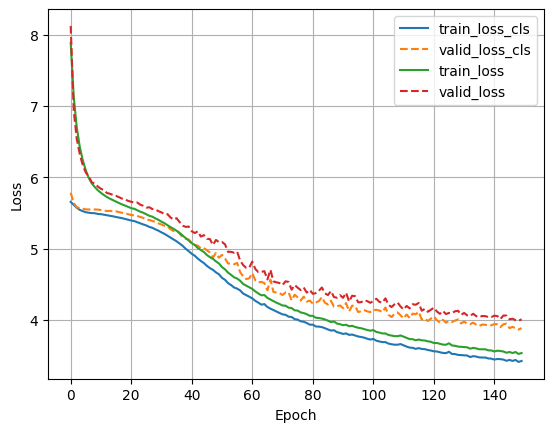

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


train_loss = pd.read_table('./output/train_loss_DPAv4.csv',sep=",")
valid_loss = pd.read_table('./output/valid_loss_DPAv4.csv',sep=",")

for i in ['loss_cls','loss']:
    h, = plt.plot(train_loss[i],'-',label='train_'+i)
    h, = plt.plot(valid_loss[i],'--',label='valid_'+i)
plt.legend()

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.savefig('./output/loss_DPAv4.eps', format='eps')

In [9]:
from src.model import ACNN_DPAv4
from src.utils import get_parameter_number

model = ACNN_DPAv4(256)
print(get_parameter_number(model))

the number of netwrok parameters: 6515, trainable parameters: 6515


# Attacking

### Case I

In [10]:
## Creating attacking set1.
Xa, Ya = np.load(folder_path+'/X_attack.npy'), np.load(folder_path+'/Y_attack.npy')
Pa, Ra = np.load(folder_path+'/P_attack.npy'), np.load(folder_path+'/R_attack.npy')
print(Xa.shape, Ya.shape, Pa.shape, Ra.shape)
offset_c1, attack_trs_c1 = traces_random_start(traces=Xa, base=trace_offset, l=2000, max_offset=350)

ps, pe = 570, 910
pr = pe - ps

# target AOI for attack traces 
attack_ps, attack_pr = ps*np.ones_like(offset_c1)-offset_c1, pr*np.ones_like(offset_c1)
attack_ps, attack_pr = attack_ps.reshape(-1,1), attack_pr.reshape(-1,1)
Ya = Ya.reshape(-1,1)
attack_label_c1 = np.concatenate([attack_ps+attack_pr//2, attack_pr, Ya], axis=1)

np.save(attack_c1_folder_path+'/X_attack.npy',attack_trs_c1)
np.save(attack_c1_folder_path+'/Y_attack.npy',attack_label_c1)
np.save(attack_c1_folder_path+'/P_attack.npy',Pa)
np.save(attack_c1_folder_path+'/R_attack.npy',Ra)
print(attack_trs_c1.shape, attack_label_c1.shape, Pa.shape, Ra.shape)

(500, 300000) (500,) (500,) (500,)
(500, 2000) (500, 3) (500,) (500,)


In [17]:
%%bash

python ./src/test.py --file_path='/run/media/declan/sda1/open_dataset/DPA_v4_2_dataset_all/ACNN/attack/c1' \
                --model='./models/DPAv4_best.pth' \
                --name=DPAv4 \
                --batch_size=256 \
                --trace_length=2000 \
                --nb_class=256 \
                --nb_attack=500 \
                --trace_offset=0 \
                --thres_nms=0.6 \
                --thres_conf=0.85 \
                --max_det=2 \
                --key=130 \
                --stride=150 \
                --GE=True \
                --showinstance=3 \


Environment information:
System: Linux 5.15.133-1-MANJARO
Not using the poetry package
Current Commit Hash: 8e36ff4
Command line arguments: Namespace(file_path='/run/media/declan/sda1/open_dataset/DPA_v4_2_dataset_all/ACNN/attack/c1', model='./models/DPAv4_best.pth', name='DPAv4', batch_size=256, trace_length=2000, nb_class=256, nb_attack=500, trace_offset=0, thres_nms=0.6, thres_conf=0.85, max_det=2, key=130, stride=150, byte=None, frequency='False', showinstance=3, GE='True')
Model saved from epoch-149


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### Case II

In [12]:
## Creating attacking set2.
Xa, Ya = np.load(folder_path+'/X_attack.npy'), np.load(folder_path+'/Y_attack.npy')
Pa, Ra = np.load(folder_path+'/P_attack.npy'), np.load(folder_path+'/R_attack.npy')
print(Xa.shape, Ya.shape, Pa.shape, Ra.shape)
base = 250000
attack_trs_c2 = traces_raw(traces=Xa, base=base, l=50000)

ps, pe = 570,910
pr = pe - ps

ps_c2 = ps+(trace_offset-base)
# target AOI for attack traces 
attack_ps, attack_pr = ps_c2*np.ones([len(attack_trs_c2), 1]), pr*np.ones([len(attack_trs_c2), 1])
Ya = Ya.reshape(-1,1)
attack_label_c2 = np.concatenate([attack_ps+attack_pr//2, attack_pr, Ya], axis=1)

np.save(attack_c2_folder_path+'/X_attack.npy',attack_trs_c2)
np.save(attack_c2_folder_path+'/Y_attack.npy',attack_label_c2)
np.save(attack_c2_folder_path+'/P_attack.npy',Pa)
np.save(attack_c2_folder_path+'/R_attack.npy',Ra)
print(attack_trs_c2.shape, attack_label_c2.shape, Pa.shape, Ra.shape)

(500, 300000) (500,) (500,) (500,)
(500, 50000) (500, 3) (500,) (500,)


In [18]:
%%bash

python ./src/test.py --file_path='/run/media/declan/sda1/open_dataset/DPA_v4_2_dataset_all/ACNN/attack/c2' \
                --model='./models/DPAv4_best.pth' \
                --name=DPAv4 \
                --batch_size=256 \
                --trace_length=50000 \
                --nb_class=256 \
                --nb_attack=500 \
                --trace_offset=250000 \
                --thres_nms=0.6 \
                --thres_conf=0.85 \
                --max_det=4 \
                --key=130 \
                --stride=150 \
                --frequency=True \

Environment information:
System: Linux 5.15.133-1-MANJARO
Not using the poetry package
Current Commit Hash: 06e3a94
Command line arguments: Namespace(file_path='/run/media/declan/sda1/open_dataset/DPA_v4_2_dataset_all/ACNN/attack/c2', model='./models/DPAv4_best.pth', name='DPAv4', batch_size=256, trace_length=50000, nb_class=256, nb_attack=500, trace_offset=250000, thres_nms=0.6, thres_conf=0.85, max_det=4, key=130, stride=150, byte=None, frequency='True', showinstance=None, GE='True', save_plot='True')
Model saved from epoch-149


Testing: 100%|██████████| 2/2 [00:49<00:00, 24.90s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
